# Imports

In [1]:
import pandas as pd
import string
import os
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import gensim
from gensim.models import Word2Vec

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Conv1D, Dropout, Activation, GlobalMaxPooling1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-Processing

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/georgie-talukdar/Can-you-judge-a-book-by-its-cover/main/Data/tabular_classification.csv')

In [4]:
df.head()

,Title,ID,Cover,Genres,Action and Adventure,Animals,Art,Children,Contemporary,Crime,...,War,Women,author,year,total_weeks,first_week,debut_rank,best_rank,Equal-Frequency,success
0,H IS FOR HOMICIDE,/works/OL14852185W,579109,"['Women', 'Mystery and Detective', 'Fiction']",0,0,0,0,0,0,...,0,1,Sue Grafton,1991,15,1991-05-05,15,2,13.0 < x ≤ 178.0,excellent
1,H IS FOR HOMICIDE,/works/OL14852185W,3108161,"['Women', 'Mystery and Detective', 'Fiction']",0,0,0,0,0,0,...,0,1,Sue Grafton,1991,15,1991-05-05,15,2,13.0 < x ≤ 178.0,excellent
2,H IS FOR HOMICIDE,/works/OL14852185W,226697,"['Women', 'Mystery and Detective', 'Fiction']",0,0,0,0,0,0,...,0,1,Sue Grafton,1991,15,1991-05-05,15,2,13.0 < x ≤ 178.0,excellent
3,I IS FOR INNOCENT,/works/OL14852192W,579110,"['Fiction', 'Women', 'Mystery and Detective']",0,0,0,0,0,0,...,0,1,Sue Grafton,1992,11,1992-04-26,2,2,7.0 < x ≤ 13.0,good
4,G IS FOR GUMSHOE,/works/OL14852180W,579057,"['Women', 'Mystery and Detective', 'Fiction']",0,0,0,0,0,0,...,0,1,Sue Grafton,1990,6,1990-05-06,8,8,4.0 < x ≤ 7.0,average


In [5]:
df = df.drop(['ID', 'Genres', 'total_weeks','Equal-Frequency'], axis=1)

In [6]:
df.head()

,Title,Cover,Action and Adventure,Animals,Art,Children,Contemporary,Crime,Death,Dystopian,...,Thriller,Travel,War,Women,author,year,first_week,debut_rank,best_rank,success
0,H IS FOR HOMICIDE,579109,0,0,0,0,0,0,0,0,...,0,0,0,1,Sue Grafton,1991,1991-05-05,15,2,excellent
1,H IS FOR HOMICIDE,3108161,0,0,0,0,0,0,0,0,...,0,0,0,1,Sue Grafton,1991,1991-05-05,15,2,excellent
2,H IS FOR HOMICIDE,226697,0,0,0,0,0,0,0,0,...,0,0,0,1,Sue Grafton,1991,1991-05-05,15,2,excellent
3,I IS FOR INNOCENT,579110,0,0,0,0,0,0,0,0,...,0,0,0,1,Sue Grafton,1992,1992-04-26,2,2,good
4,G IS FOR GUMSHOE,579057,0,0,0,0,0,0,0,0,...,0,0,0,1,Sue Grafton,1990,1990-05-06,8,8,average


## Title

In [7]:
# Clean data using the built in cleaner in gensim
df['text_clean'] = df['Title'].apply(lambda x: gensim.utils.simple_preprocess(x))
df = df.drop(['Title'], axis=1)
df.head()

,Cover,Action and Adventure,Animals,Art,Children,Contemporary,Crime,Death,Dystopian,Espionage,...,Travel,War,Women,author,year,first_week,debut_rank,best_rank,success,text_clean
0,579109,0,0,0,0,0,0,0,0,0,...,0,0,1,Sue Grafton,1991,1991-05-05,15,2,excellent,"[is, for, homicide]"
1,3108161,0,0,0,0,0,0,0,0,0,...,0,0,1,Sue Grafton,1991,1991-05-05,15,2,excellent,"[is, for, homicide]"
2,226697,0,0,0,0,0,0,0,0,0,...,0,0,1,Sue Grafton,1991,1991-05-05,15,2,excellent,"[is, for, homicide]"
3,579110,0,0,0,0,0,0,0,0,0,...,0,0,1,Sue Grafton,1992,1992-04-26,2,2,good,"[is, for, innocent]"
4,579057,0,0,0,0,0,0,0,0,0,...,0,0,1,Sue Grafton,1990,1990-05-06,8,8,average,"[is, for, gumshoe]"


## Author

In [8]:
df['author'] = df['author'].apply(lambda x: x.lower())
df['author'] = df['author'].str.replace('[{}]'.format(string.punctuation), ' ')

<ipython-input-8-5f3f9a32e576>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['author'] = df['author'].str.replace('[{}]'.format(string.punctuation), ' ')


In [9]:
# Extract the 'author' column as a separate DataFrame
author_column = df[['author']]

# Create an instance of OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the 'author' column
onehot_encoded = encoder.fit_transform(author_column)

# Convert the sparse matrix to a dense array
onehot_encoded = onehot_encoded.toarray()

# Create a new DataFrame with the one-hot encoded features
onehot_df = pd.DataFrame(onehot_encoded, columns=encoder.categories_[0])

# Concatenate the one-hot encoded DataFrame with the original DataFrame
textual_df_encoded = pd.concat([df, onehot_df], axis=1)

textual_df_encoded.head()

,Cover,Action and Adventure,Animals,Art,Children,Contemporary,Crime,Death,Dystopian,Espionage,...,winifred holtby,winston groom,wm paul young,yaa gyasi,yael dayan,yangsze choo,yann martel,yukio mishima,zadie smith,zoe oldenbourg
0,579109,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3108161,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,226697,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,579110,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,579057,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
textual_df_encoded = textual_df_encoded.drop(['author','year'], axis=1)

In [11]:
column_names = textual_df_encoded.columns.tolist()
print(column_names)

['Cover', 'Action and Adventure', 'Animals', 'Art', 'Children', 'Contemporary', 'Crime', 'Death', 'Dystopian', 'Espionage', 'Family', 'Fantasy', 'Fiction', 'Friendship', 'Health', 'Historical', 'Horror', 'Humor', 'Legal', 'Memoir', 'Murder', 'Mystery and Detective', 'Paranormal', 'Political', 'Psychological', 'Relationships', 'Romance', 'Self-help', 'Suspense', 'Thriller', 'Travel', 'War', 'Women', 'first_week', 'debut_rank', 'best_rank', 'success', 'text_clean', '  martha grimes', ' elizabeth forsythe hailey', ' james a  michener', 'a  a  milne', 'a  j  cronin', 'a  s  byatt', 'a a  milnei', 'a b  guthrie  jr', 'a b  guthrie jr', 'a c  crispin', 'a j  cronin', 'a j  finn', 'aaron allston', 'abi daré', 'ace atkins', 'adam haslett', 'adam johnson', 'adela rogers st  johns', 'adrian mckinty', 'adriana trigiani', 'adèle lang', 'agatha christie', 'agatha young', 'agnes newton keith', 'agnes sligh turnbull', 'aimee bender', 'akwaeke emezi', 'al dewlen', 'alan bradley', 'alan dean foster', '

## Date

In [12]:
textual_df_encoded['first_week'] = pd.to_datetime(textual_df_encoded['first_week'])

In [13]:
textual_df_encoded['first_week'].head(5)


0   1991-05-05
1   1991-05-05
2   1991-05-05
3   1992-04-26
4   1990-05-06
Name: first_week, dtype: datetime64[ns]

In [14]:
# change data into month and day
textual_df_encoded['first_month'] = textual_df_encoded['first_week'].dt.month
textual_df_encoded['first_day'] = textual_df_encoded['first_week'].dt.day

textual_df_encoded = textual_df_encoded.drop(['first_week'], axis=1)

In [15]:
textual_df_encoded.head()

,Cover,Action and Adventure,Animals,Art,Children,Contemporary,Crime,Death,Dystopian,Espionage,...,wm paul young,yaa gyasi,yael dayan,yangsze choo,yann martel,yukio mishima,zadie smith,zoe oldenbourg,first_month,first_day
0,579109,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
1,3108161,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
2,226697,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
3,579110,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,26
4,579057,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,6


## Image

In [ ]:
!unzip /content/drive/MyDrive/covers/label_images.zip -d /content/label

In [17]:
def image_generator(image_dir, batch_size, image_size):
    images = []
    labels = []
    cover_ids = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            filepath = os.path.join(image_dir, filename)
            cover_id, label, _ = filename.split('_')  # Extract the cover ID and label

            # Load and preprocess the image
            image = cv2.imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            image = cv2.resize(image, image_size)  # Resize the image
            image = image / 255.0  # Normalize pixel values to the range of 0-1

            images.append(image)
            labels.append(label)
            cover_ids.append(cover_id)

            if len(images) == batch_size:
                yield np.array(images), np.array(labels), np.array(cover_ids)
                images = []
                labels = []
                cover_ids = []

    if images:  # Yield the remaining images if the total count is not a multiple of batch_size
        yield np.array(images), np.array(labels), np.array(cover_ids)


In [18]:
image_dir = '/content/label'
image_size = (224, 224)
batch_size = 32

In [19]:
# Generate the data using the image generator
data_generator = image_generator(image_dir, batch_size, image_size)
X, y, cover_ids = zip(*data_generator)

# Convert the generator output to arrays
X = np.concatenate(X)
y = np.concatenate(y)
cover_ids = np.concatenate(cover_ids)

# Split the dataset into training and testing sets with equal class distribution
X_train_val, X_test, y_train_val, y_test, cover_ids_train_val, cover_ids_test = train_test_split(
    X, y, cover_ids, test_size=0.2, random_state=123, stratify=y
)

# Split the training and validation sets with equal class distribution
X_train, X_val, y_train, y_val, cover_ids_train, cover_ids_val = train_test_split(
    X_train_val, y_train_val, cover_ids_train_val, test_size=0.2, random_state=123, stratify=y_train_val
)


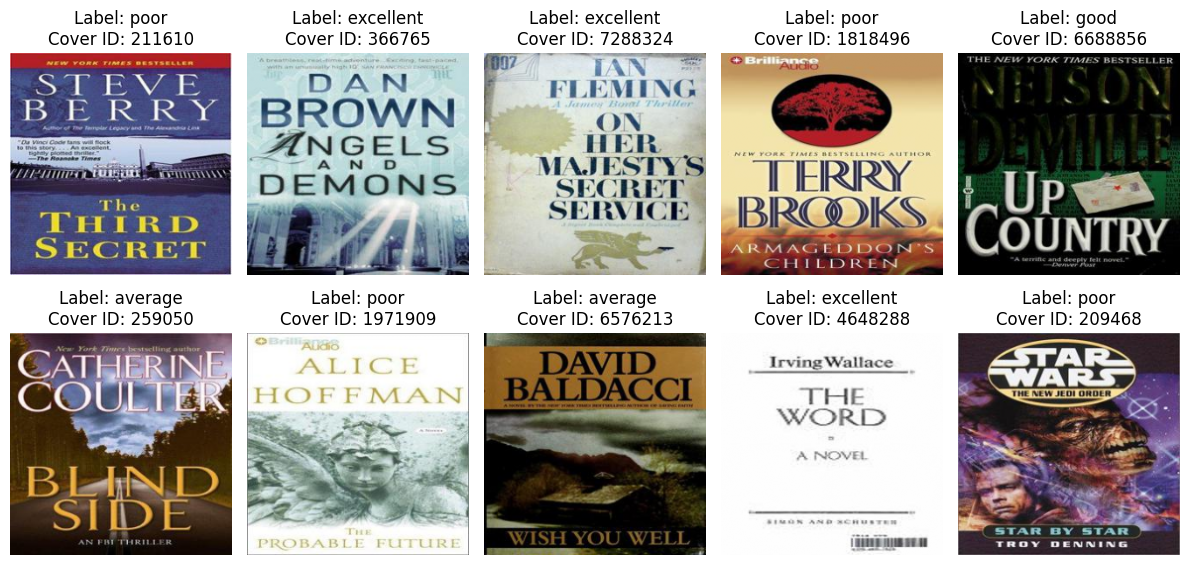

In [20]:
# Define a function to display images, labels, and cover IDs
def display_images(images, labels, cover_ids):
    fig, axs = plt.subplots(2, 5, figsize=(12, 6))
    axs = axs.ravel()

    for i in range(10):
        axs[i].imshow(images[i])
        axs[i].set_title(f"Label: {labels[i]}\nCover ID: {cover_ids[i]}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display some images, labels, and cover IDs from the training set
display_images(X_train[:10], y_train[:10], cover_ids_train[:10])


## Train test split

In [21]:
cover_ids_test = [int(x) for x in cover_ids_test]
cover_ids_train = [int(x) for x in cover_ids_train]
cover_ids_val = [int(x) for x in cover_ids_val]

In [22]:
# Initialize an empty DataFrame to store the desired rows
textual_test = pd.DataFrame()

# Iterate through the array of numbers
for desired_value in cover_ids_test:
    # Use loc to filter the DataFrame based on the desired column value
    desired_row = textual_df_encoded.loc[textual_df_encoded['Cover'] == desired_value]

    # Append the desired row to the DataFrame
    textual_test = textual_test.append(desired_row, ignore_index=True)

<ipython-input-22-fb4d69ea69cd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  textual_test = textual_test.append(desired_row, ignore_index=True)


In [23]:
# Initialize an empty DataFrame to store the desired rows
textual_train = pd.DataFrame()

# Iterate through the array of numbers
for desired_value in cover_ids_train:
    # Use loc to filter the DataFrame based on the desired column value
    desired_row = textual_df_encoded.loc[textual_df_encoded['Cover'] == desired_value]

    # Append the desired row to the DataFrame
    textual_train = textual_train.append(desired_row, ignore_index=True)

<ipython-input-23-fb403b65acd3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  textual_train = textual_train.append(desired_row, ignore_index=True)


In [24]:
# Initialize an empty DataFrame to store the desired rows
textual_val = pd.DataFrame()

# Iterate through the array of numbers
for desired_value in cover_ids_val:
    # Use loc to filter the DataFrame based on the desired column value
    desired_row = textual_df_encoded.loc[textual_df_encoded['Cover'] == desired_value]

    # Append the desired row to the DataFrame
    textual_val = textual_val.append(desired_row, ignore_index=True)

<ipython-input-24-4ee4aaac3cd8>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  textual_val = textual_val.append(desired_row, ignore_index=True)


In [25]:
import pandas as pd

unique_counts = textual_val['success'].value_counts()

print(unique_counts)


poor         401
excellent    273
average      234
good         231
mediocre     225
Name: success, dtype: int64


In [26]:
import pandas as pd

unique_counts = textual_test['success'].value_counts()

print(unique_counts)


poor         502
excellent    341
average      293
good         288
mediocre     282
Name: success, dtype: int64


In [27]:
import pandas as pd

unique_counts = textual_train['success'].value_counts()

print(unique_counts)

poor         1605
excellent    1092
average       935
good          922
mediocre      902
Name: success, dtype: int64


In [28]:
y_train_textual = textual_train[['success']]
X_train_textual = textual_train.drop(['success','Cover'], axis=1)

y_test_textual = textual_test[['success']]
X_test_textual = textual_test.drop(['success','Cover'], axis=1)

y_val_textual = textual_val[['success']]
X_val_textual = textual_val.drop(['success','Cover'], axis=1)

In [29]:
# Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_textual)
y_test_encoded = label_encoder.transform(y_test_textual)
y_val_encoded = label_encoder.transform(y_val_textual)

# Convert labels to one-hot encoded format
y_train_textual = to_categorical(y_train_encoded, num_classes=5)
y_test_textual = to_categorical(y_test_encoded, num_classes=5)
y_val_textual = to_categorical(y_val_encoded, num_classes=5)

# Reverse the one-hot encoding and get the original label names
reverse_mapping = {index: label for index, label in enumerate(label_encoder.inverse_transform(range(len(label_encoder.classes_))))}

# Create a mapping dictionary for later use
mapping_dict = {index: category for index, category in reverse_mapping.items()}

# Print the mapping values to the categorical labels
for index, category in mapping_dict.items():
    print(f"Value: {index} - Category: {category}")


Value: 0 - Category: average
Value: 1 - Category: excellent
Value: 2 - Category: good
Value: 3 - Category: mediocre
Value: 4 - Category: poor


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [30]:
y_val_textual

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [31]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train_textual['text_clean'],
                                   vector_size=200,
                                   window=5,
                                   min_count=1)

In [ ]:
w2v_model.wv.index_to_key

In [33]:
w2v_model.wv.most_similar('murder')

[('midnight', 0.5181623101234436),
 ('and', 0.5147928595542908),
 ('of', 0.5049089193344116),
 ('to', 0.5038514137268066),
 ('for', 0.5027111768722534),
 ('on', 0.5025032162666321),
 ('the', 0.49941286444664),
 ('last', 0.49871790409088135),
 ('my', 0.497355580329895),
 ('star', 0.4965251386165619)]

In [34]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train_textual['text_clean']], dtype=object)
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test_textual['text_clean']], dtype=object)
X_val_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_val_textual['text_clean']], dtype=object)

In [35]:
X_val_vect.size

1364

In [36]:
X_train_vect_avg = []
for v, row in zip(X_train_vect, X_train_textual.iterrows()):
    author_features = row[1].drop('text_clean').values
    if v.size:
        sentence_vector = np.concatenate([v.mean(axis=0), author_features])
    else:
        sentence_vector = np.concatenate([np.zeros(200, dtype=float), author_features])
    X_train_vect_avg.append(sentence_vector)

X_test_vect_avg = []
for v, row in zip(X_test_vect, X_test_textual.iterrows()):
    author_features = row[1].drop('text_clean').values
    if v.size:
        sentence_vector = np.concatenate([v.mean(axis=0), author_features])
    else:
        sentence_vector = np.concatenate([np.zeros(200, dtype=float), author_features])
    X_test_vect_avg.append(sentence_vector)

X_val_vect_avg = []
for v, row in zip(X_val_vect, X_val_textual.iterrows()):
    author_features = row[1].drop('text_clean').values
    if v.size:
        sentence_vector = np.concatenate([v.mean(axis=0), author_features])
    else:
        sentence_vector = np.concatenate([np.zeros(200, dtype=float), author_features])
    X_val_vect_avg.append(sentence_vector)


In [37]:
labels = ['poor', 'mediocre', 'average', 'good', 'excellent']

In [38]:
X_val_vect_avg

[array([0.003809453919529915, -0.009870922192931175, 0.004807575140148401,
        ..., 0.0, 3, 17], dtype=object),
 array([-0.0010231503983959556, 0.0027199597097933292,
        0.0034343928564339876, ..., 0.0, 8, 19], dtype=object),
 array([0.006682997103780508, -0.011691613122820854, 0.0041168443858623505,
        ..., 0.0, 5, 9], dtype=object),
 array([6.887437484692782e-05, -0.003929810132831335,
        0.0014860618393868208, ..., 0.0, 5, 14], dtype=object),
 array([0.006742091849446297, -0.007632946129888296, 0.0025538275949656963,
        ..., 0.0, 4, 6], dtype=object),
 array([0.004207392688840628, -0.0003504290652927011,
        0.0027900375425815582, ..., 0.0, 7, 19], dtype=object),
 array([0.005084692034870386, -0.008286993950605392, 0.0032038188073784113,
        ..., 0.0, 11, 15], dtype=object),
 array([0.0032075366470962763, -0.005840581376105547,
        -9.520254388917238e-05, ..., 0.0, 11, 25], dtype=object),
 array([0.0016091172583401203, 0.0018528455402702093,
     

# Models

## Model 1

In [45]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionResNetV2
from sklearn.metrics import precision_score, recall_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
import os

X_train_vect_avg = np.array(X_train_vect_avg, dtype=np.float32)
X_test_vect_avg = np.array(X_test_vect_avg, dtype=np.float32)
X_val_vect_avg = np.array(X_val_vect_avg, dtype=np.float32)

# Define the input shape based on X_train_vect_avg
input_shape = X_train_vect_avg.shape[1:]

# model architecture
input_text = Input(shape=input_shape)
word_encoder = Dense(units=64, activation='relu')(input_text)
interaction = Dense(units=5, activation='softmax')(word_encoder)
output = Dense(units=5, activation='softmax')(interaction)

# Build the model
model = Model(inputs=input_text, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Get the output layer of the tabular model
tabular_output = model.layers[-2].output

# Define the image input shape
image_input_shape = (224, 224, 3)

# Create the tabular input
tabular_input = model.input

# Add more fully connected layers to tabular features
tabular_fc = Dense(32, activation='relu')(tabular_output)
tabular_fc = Dense(16, activation='relu')(tabular_fc)

# Create the image input
image_input = Input(shape=image_input_shape, name='image_input')
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=image_input_shape)
image_features = base_model(image_input)
image_features = GlobalAveragePooling2D()(image_features)

# Concatenate the tabular and image features
combined_features = concatenate([tabular_fc, image_features])

# Add more fully connected layers
fc = Dense(64, activation='relu')(combined_features)
output = Dense(5, activation='softmax')(fc)

# Create the multimodal model
model = Model(inputs=[tabular_input, image_input], outputs=output)

# Freeze the layers of the image base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
model.fit([X_train_vect_avg, X_train], y_train_textual, epochs=100, batch_size=32,
          validation_data=([X_val_vect_avg, X_val], y_val_textual), callbacks=[early_stopping])

Epoch 1/100
171/171 [==============================] - 23s 67ms/step - loss: 1.5655 - accuracy: 0.2980 - val_loss: 1.3784 - val_accuracy: 0.4567
Epoch 2/100
171/171 [==============================] - 7s 41ms/step - loss: 1.1408 - accuracy: 0.5161 - val_loss: 1.0730 - val_accuracy: 0.5242
Epoch 3/100
171/171 [==============================] - 7s 40ms/step - loss: 0.9788 - accuracy: 0.5825 - val_loss: 1.1121 - val_accuracy: 0.5227
Epoch 4/100
171/171 [==============================] - 7s 40ms/step - loss: 0.9127 - accuracy: 0.6169 - val_loss: 0.9929 - val_accuracy: 0.5726
Epoch 5/100
171/171 [==============================] - 7s 41ms/step - loss: 0.8313 - accuracy: 0.6604 - val_loss: 0.9690 - val_accuracy: 0.5997
Epoch 6/100
171/171 [==============================] - 7s 41ms/step - loss: 0.8123 - accuracy: 0.6615 - val_loss: 0.9672 - val_accuracy: 0.5718
Epoch 7/100
171/171 [==============================] - 7s 40ms/step - loss: 0.7302 - accuracy: 0.7011 - val_loss: 0.9597 - val_accuracy

In [ ]:
# Save the best model weights
save_dir = '/content/drive/MyDrive/covers/model_5_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'model_1_weights.h5'))

In [46]:
# Use the trained model to make predictions on the test data
y_pred_prob = model.predict([X_test_vect_avg, X_test])
y_pred = np.argmax(y_pred_prob, axis=1)

y_pred = to_categorical(y_pred, num_classes=5)

# Calculate precision, recall, and accuracy scores
precision = precision_score(y_test_textual, y_pred, average='macro')
recall = recall_score(y_test_textual, y_pred, average='macro')
accuracy = ((y_pred == y_test_textual).sum() / len(y_pred))/10
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(accuracy, 3)))

# Generate classification report
report = classification_report(y_test_textual, y_pred, target_names=labels)
print("Classification Report:")
print(report)

54/54 [==============================] - 5s 26ms/step
Precision: 0.556 / Recall: 0.55 / Accuracy: 0.418
Classification Report:
              precision    recall  f1-score   support

        poor       0.45      0.30      0.36       293
    mediocre       0.73      0.70      0.71       341
     average       0.42      0.55      0.47       288
        good       0.46      0.37      0.41       282
   excellent       0.73      0.84      0.78       502

   micro avg       0.59      0.59      0.59      1706
   macro avg       0.56      0.55      0.55      1706
weighted avg       0.58      0.59      0.58      1706
 samples avg       0.59      0.59      0.59      1706



54/54 [==============================] - 1s 26ms/step


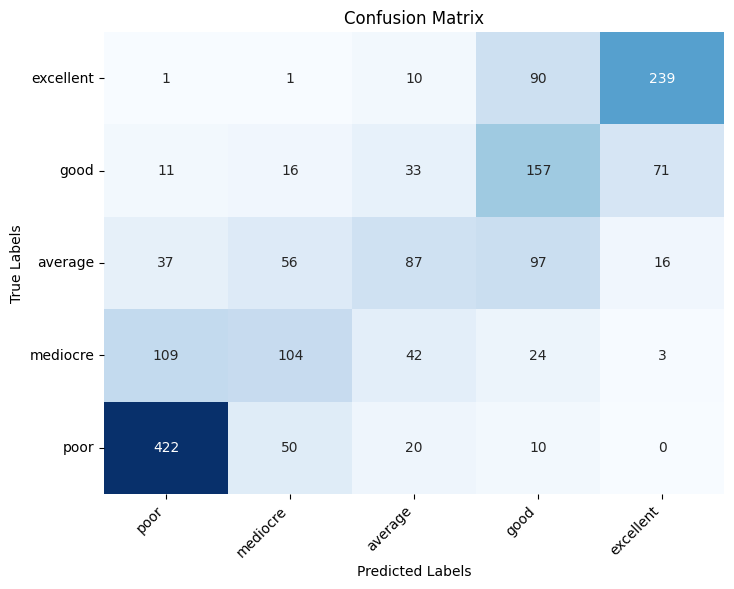

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Perform predictions on the test data
y_pred_prob = model.predict([X_test_vect_avg, X_test])
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded predicted labels to categorical labels
y_pred_categorical = np.argmax(y_pred_prob, axis=1)

# Decode the categorical labels to original labels using the mapping dictionary
y_test_decoded = [mapping_dict[label] for label in np.argmax(y_test_textual, axis=1)]
y_pred_decoded = [mapping_dict[label] for label in y_pred_categorical]

# Create the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

# Show the confusion matrix
plt.show()


## Model 2

In [ ]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2
from sklearn.metrics import precision_score, recall_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
import os

X_train_vect_avg = np.array(X_train_vect_avg, dtype=np.float32)
X_test_vect_avg = np.array(X_test_vect_avg, dtype=np.float32)
X_val_vect_avg = np.array(X_val_vect_avg, dtype=np.float32)

# Define the input shape based on X_train_vect_avg
input_shape = X_train_vect_avg.shape[1:]

# Model architecture for tabular data
input_text = Input(shape=input_shape)
word_encoder = Dense(units=64, activation='relu')(input_text)
interaction = Dense(units=5, activation='softmax')(word_encoder)
output = Dense(units=5, activation='softmax')(interaction)

# Build the tabular model
tabular_model = Model(inputs=input_text, outputs=output)

# Load the pre-trained tabular model weights
tabular_model.load_weights('/content/drive/MyDrive/covers/model_3_weights/EXAM_weights.h5')

# Get the output layer of the tabular model
tabular_output = tabular_model.layers[-2].output

# Define the image input shape
image_input_shape = (224, 224, 3)

# Create the tabular input
tabular_input = tabular_model.input

# Create the image input
image_input = Input(shape=image_input_shape, name='image_input')
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=image_input_shape)
image_features = base_model(image_input)
image_features = GlobalAveragePooling2D()(image_features)

# Concatenate the tabular and image features
combined_features = concatenate([tabular_output, image_features])

# Add more fully connected layers
fc = Dense(64, activation='relu')(combined_features)
output = Dense(5, activation='softmax')(fc)

# Create the multimodal model
model = Model(inputs=[tabular_input, image_input], outputs=output)

# Freeze the layers of the tabular model
for layer in tabular_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
model.fit([X_train_vect_avg, X_train], y_train_textual, epochs=100, batch_size=32,
          validation_data=([X_val_vect_avg, X_val], y_val_textual), callbacks=[early_stopping])

# Save the best model weights
save_dir = '/content/drive/MyDrive/covers/model_5_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'model_2_weights.h5'))


Epoch 1/100
171/171 [==============================] - 151s 258ms/step - loss: 1.4816 - accuracy: 0.3858 - val_loss: 1.6054 - val_accuracy: 0.2940
Epoch 2/100
171/171 [==============================] - 38s 224ms/step - loss: 1.2308 - accuracy: 0.5273 - val_loss: 1.1838 - val_accuracy: 0.5528
Epoch 3/100
171/171 [==============================] - 38s 221ms/step - loss: 1.1603 - accuracy: 0.5348 - val_loss: 1.5013 - val_accuracy: 0.3497
Epoch 4/100
171/171 [==============================] - 38s 221ms/step - loss: 1.1466 - accuracy: 0.5460 - val_loss: 1.3778 - val_accuracy: 0.4208
Epoch 5/100
171/171 [==============================] - 38s 223ms/step - loss: 1.1350 - accuracy: 0.5532 - val_loss: 1.1748 - val_accuracy: 0.5425
Epoch 6/100
171/171 [==============================] - 38s 221ms/step - loss: 1.1299 - accuracy: 0.5557 - val_loss: 1.3325 - val_accuracy: 0.4479
Epoch 7/100
171/171 [==============================] - 38s 223ms/step - loss: 1.1247 - accuracy: 0.5607 - val_loss: 1.1655 

54/54 [==============================] - 3s 62ms/step


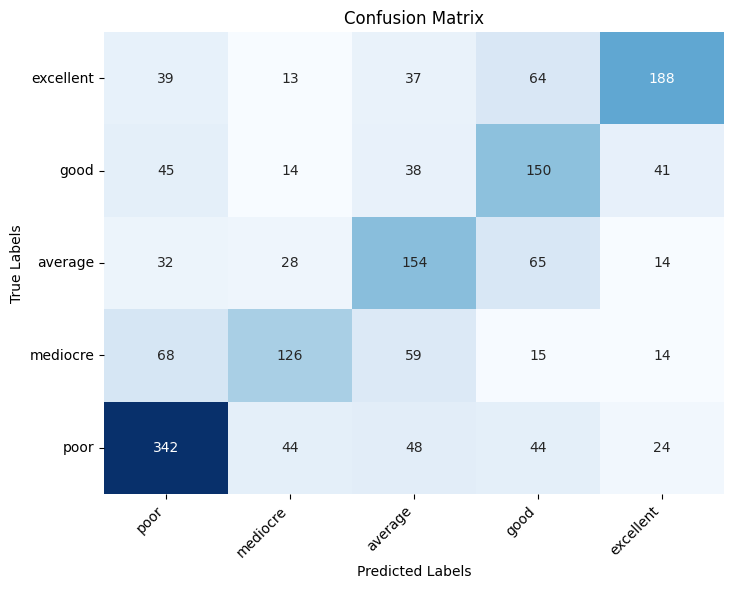

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Perform predictions on the test data
y_pred_prob = model.predict([X_test_vect_avg, X_test])
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded predicted labels to categorical labels
y_pred_categorical = np.argmax(y_pred_prob, axis=1)

# Decode the categorical labels to original labels using the mapping dictionary
y_test_decoded = [mapping_dict[label] for label in np.argmax(y_test_textual, axis=1)]
y_pred_decoded = [mapping_dict[label] for label in y_pred_categorical]

# Create the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

# Show the confusion matrix
plt.show()


In [ ]:
# Use the trained model to make predictions on the test data
y_pred_prob = model.predict([X_test_vect_avg, X_test])
y_pred = np.argmax(y_pred_prob, axis=1)

y_pred = to_categorical(y_pred, num_classes=5)

# Calculate precision, recall, and accuracy scores
precision = precision_score(y_test_textual, y_pred, average='macro')
recall = recall_score(y_test_textual, y_pred, average='macro')
accuracy = ((y_pred == y_test_textual).sum() / len(y_pred))/10
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(accuracy, 3)))

# Generate classification report
report = classification_report(y_test_textual, y_pred, target_names=labels)
print("Classification Report:")
print(report)

54/54 [==============================] - 8s 62ms/step
Precision: 0.556 / Recall: 0.545 / Accuracy: 0.413
Classification Report:
              precision    recall  f1-score   support

        poor       0.46      0.53      0.49       293
    mediocre       0.67      0.55      0.60       341
     average       0.44      0.52      0.48       288
        good       0.56      0.45      0.50       282
   excellent       0.65      0.68      0.67       502

   micro avg       0.56      0.56      0.56      1706
   macro avg       0.56      0.55      0.55      1706
weighted avg       0.57      0.56      0.56      1706
 samples avg       0.56      0.56      0.56      1706



## Model 3

In [55]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2
from sklearn.metrics import precision_score, recall_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.constraints import MaxNorm
import os

# Define the input shape for tabular data
tabular_input_shape = X_train_vect_avg.shape[1:]

# Define the input shape for the image data
image_input_shape = (224, 224, 3)

# Define the number of classes
num_classes = 5

# Pretrain the tabular subnetwork
tabular_input = Input(shape=tabular_input_shape)
tabular_encoder = Dense(units=64, activation='relu', kernel_constraint=MaxNorm(3))(tabular_input)
tabular_output = Dense(units=num_classes, activation='softmax', kernel_constraint=MaxNorm(3))(tabular_encoder)

tabular_model = Model(inputs=tabular_input, outputs=tabular_output)

# Compile the tabular subnetwork
tabular_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the tabular subnetwork
tabular_model.fit(X_train_vect_avg, y_train_textual, epochs=100, batch_size=32,
                  validation_data=(X_val_vect_avg, y_val_textual), callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

# Freeze the weights of the tabular subnetwork
tabular_model.trainable = False

# Pretrain the image subnetwork
image_input = Input(shape=image_input_shape, name='image_input')
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=image_input_shape)
image_features = base_model(image_input)
image_features = GlobalAveragePooling2D()(image_features)

image_output = Dense(units=num_classes, activation='softmax', kernel_constraint=MaxNorm(3))(image_features)

image_model = Model(inputs=image_input, outputs=image_output)

# Compile the image subnetwork
image_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the image subnetwork
image_model.fit(X_train, y_train_textual, epochs=100, batch_size=32,
                validation_data=(X_val, y_val_textual), callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

# Freeze the weights of the image subnetwork
image_model.trainable = False

# Combine the subnetworks
combined_features = concatenate([tabular_model.output, image_model.output])

# Add more fully connected layers
fc = Dense(64, activation='relu', kernel_constraint=MaxNorm(3))(combined_features)
output = Dense(num_classes, activation='softmax')(fc)

# Create the multimodal model
model = Model(inputs=[tabular_model.input, image_model.input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the multimodal model
model.fit([X_train_vect_avg, X_train], y_train_textual, epochs=100, batch_size=32,
          validation_data=([X_val_vect_avg, X_val], y_val_textual), callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

# Save the best model weights
save_dir = '/content/drive/MyDrive/covers/model_5_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'model_3_weights.h5'))


Epoch 1/100
171/171 [==============================] - 2s 4ms/step - loss: 1.3346 - accuracy: 0.4533 - val_loss: 1.1689 - val_accuracy: 0.5455
Epoch 2/100
171/171 [==============================] - 1s 3ms/step - loss: 1.0809 - accuracy: 0.5742 - val_loss: 1.0461 - val_accuracy: 0.5550
Epoch 3/100
171/171 [==============================] - 1s 3ms/step - loss: 0.9612 - accuracy: 0.6215 - val_loss: 0.9595 - val_accuracy: 0.6144
Epoch 4/100
171/171 [==============================] - 1s 3ms/step - loss: 0.8796 - accuracy: 0.6589 - val_loss: 0.9212 - val_accuracy: 0.6173
Epoch 5/100
171/171 [==============================] - 1s 3ms/step - loss: 0.8132 - accuracy: 0.6895 - val_loss: 0.8841 - val_accuracy: 0.6378
Epoch 6/100
171/171 [==============================] - 1s 3ms/step - loss: 0.7653 - accuracy: 0.7146 - val_loss: 0.8803 - val_accuracy: 0.6371
Epoch 7/100
171/171 [==============================] - 1s 3ms/step - loss: 0.7375 - accuracy: 0.7258 - val_loss: 0.8901 - val_accuracy: 0.6320

In [56]:
# Use the trained model to make predictions on the test data
y_pred_prob = model.predict([X_test_vect_avg, X_test])
y_pred = np.argmax(y_pred_prob, axis=1)

y_pred = to_categorical(y_pred, num_classes=5)

# Calculate precision, recall, and accuracy scores
precision = precision_score(y_test_textual, y_pred, average='macro')
recall = recall_score(y_test_textual, y_pred, average='macro')
accuracy = ((y_pred == y_test_textual).sum() / len(y_pred))/10
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(accuracy, 3)))

# Generate classification report
report = classification_report(y_test_textual, y_pred, target_names=labels)
print("Classification Report:")
print(report)

54/54 [==============================] - 5s 26ms/step
Precision: 0.636 / Recall: 0.631 / Accuracy: 0.433
Classification Report:
              precision    recall  f1-score   support

        poor       0.48      0.50      0.49       293
    mediocre       0.82      0.80      0.81       341
     average       0.55      0.60      0.58       288
        good       0.55      0.40      0.47       282
   excellent       0.77      0.84      0.81       502

   micro avg       0.66      0.66      0.66      1706
   macro avg       0.64      0.63      0.63      1706
weighted avg       0.66      0.66      0.66      1706
 samples avg       0.66      0.66      0.66      1706



54/54 [==============================] - 1s 26ms/step


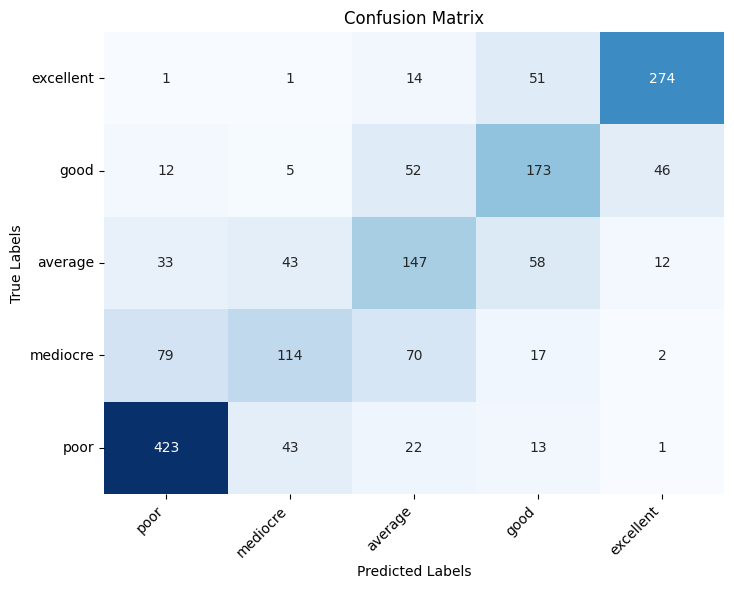

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Perform predictions on the test data
y_pred_prob = model.predict([X_test_vect_avg, X_test])
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded predicted labels to categorical labels
y_pred_categorical = np.argmax(y_pred_prob, axis=1)

# Decode the categorical labels to original labels using the mapping dictionary
y_test_decoded = [mapping_dict[label] for label in np.argmax(y_test_textual, axis=1)]
y_pred_decoded = [mapping_dict[label] for label in y_pred_categorical]

# Create the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

# Show the confusion matrix
plt.show()
